<a href="https://colab.research.google.com/github/lblabucsd/Zada_Schulze_24/blob/main/make_ego_stimulus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#this notebook is for analyzing the real interactions among 4 fish from SLEAP

#this cell loads packages

# mount the google drive folder where we want to import package/data from
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
import numpy as np
sys.path.insert(0,'/content/drive/My Drive/Personal_notebooks/Johsien_Notebook/Colab')
# add package and/or customized functions if needed as you go
#from SLEAP_pckg import *
#from BehavPlot_pckg import *

#import python packages
import os
import csv
import h5py
import subprocess
import numpy as np
import pandas as pd
import math
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy.interpolate import interp1d
import statsmodels
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from skimage.transform import resize

import random
from random import randrange
#from random import shuffle
sns.set_style("white")


print('all imported')

Mounted at /content/drive
all imported


In [ ]:
# define a bunch of functions (can move to .py file when solid)

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)

        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

#function to find index of closest value in array (good for matching different time measurements)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.argmin((np.abs(array - value)))
    return idx

#function to get the smoothed running mean
def running_mean(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

#function to resize 1D array
def resized(data,N):
    M=data.size
    res=np.empty(N,data.dtype)
    carry=0
    m=0
    for n in range(N):
        sum=carry
        while m*N - n*M < M:
            sum += data[m]
            m += 1
        carry = (m-(n+1)*M/N)*data[m-1]
        sum -= carry
        res[n] = sum*N/M
    #res *= 1.0/res.max()
    return res

#calculate angles between 2 points
def calculate_angle(X1,Y1,X2,Y2):
    rads=[];
    for x1,y1,x2,y2 in zip(X1,Y1,X2,Y2):
        dx=x1-x2
        dy=y1-y2
        rads.append(math.atan2(dy, dx))
    degs = np.rad2deg(rads)
    return degs


def get_single_angle(x1,y1,x2,y2):
    return math.degrees(math.atan2(y2-y1, x2-x1))


def pt_rotate(x, y, degrees, offset_x, offset_y):
    """Rotate a point around a given point.
    """
    #degrees to radians
    radians=np.deg2rad(degrees)
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return qx, qy


In [ ]:
#load data for animations

path = '/content/drive/MyDrive/Temporary_data_storage/Matt/Results_for_David_220802/'
fnum = '8wpf_070122_L3'
f =np.load(path+fnum+'_processed_data.npz', allow_pickle=True)
time=f['time']
bout_starts=f['bout_starts']
bout_ends=f['bout_ends']
ang_speeds=f['ang_speeds']
speeds=f['speeds']
head_xs=f['head_xs']
head_ys=f['head_ys']
head_angles=f['head_angles']
tail_xs=f['tail_xs']
tail_ys=f['tail_ys']
tail_angles=f['tail_angles']
#tail_angle_responses=f['tail_angle_responses']
visual_angles=f['visual_angles']
occupancy_maps=f['occupancy_maps']
alignment_maps=f['alignment_maps']
speed_maps=f['speed_maps']
angspeed_maps=f['angspeed_maps']

f0_x,f1_x,f2_x,f3_x = head_xs
f0_y,f1_y,f2_y,f3_y = head_ys
f0_xtip,f1_xtip,f2_xtip,f3_xtip = tail_xs
f0_ytip,f1_ytip,f2_ytip,f3_ytip = tail_ys
f0_head_angle,f1_head_angle,f2_head_angle,f3_head_angle = head_angles

time is  9.952222222222222


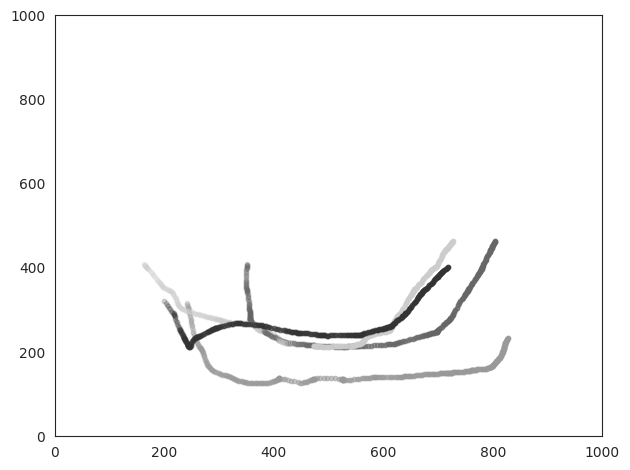

smoothed data


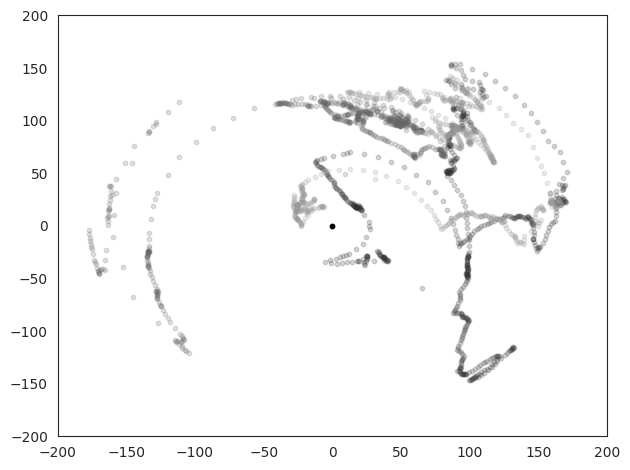

'\nfor ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):\n    plt.plot(x, color=colorz[ndx])\nplt.title(\'x\')\nplt.show()\n\nfor ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):\n    plt.plot(y, color=colorz[ndx])\nplt.title(\'y\')\nplt.show()\n\nfor ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):\n    plt.plot(a, color=colorz[ndx])\nplt.title(\'ang\')\nplt.show()\n\nX_pause = np.zeros(120)\nY_pause = np.ones(120)*20 #place behind fish\nA_pause = np.zeros(120)\n\n\nfor ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):\n  X = np.concatenate([X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause])\n  Y = np.concatenate([Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,

In [ ]:
#make egocentric stimuli (csv)

#for a given fish, get egocentric

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

figure_savepath = '/content/drive/MyDrive/Zada_Schulze_paper/Figures_output/Neural_activity/'



#find example movements to save as csv

# Plot the position and heading/tail angle over time
import scipy

import matplotlib.collections as mcoll
import matplotlib.colors as mcolors

time_start = 5500  #14500

fish1x=[];fish1y=[];fish1a=[];
fish2x=[];fish2y=[];fish2a=[];
fish3x=[];fish3y=[];fish3a=[];
Xs_csv=[fish1x,fish2x,fish3x]
Ys_csv=[fish1y,fish2y,fish3y]
Angs_csv=[fish1a,fish2a,fish3a]

print("time is ", time[599]-time[0])

for n in range(600):
    if n%2==True:
      st=n+time_start
      ed=st+2
      d0=np.mean(f0_head_angle[st:ed])
      d1=np.mean(f1_head_angle[st:ed])
      d2=np.mean(f2_head_angle[st:ed])
      d3=np.mean(f3_head_angle[st:ed])
      x0=np.mean(f0_x[st:ed])
      x1=np.mean(f1_x[st:ed])
      x2=np.mean(f2_x[st:ed])
      x3=np.mean(f3_x[st:ed])
      y0=np.mean(f0_y[st:ed])
      y1=np.mean(f1_y[st:ed])
      y2=np.mean(f2_y[st:ed])
      y3=np.mean(f3_y[st:ed])
      tx0=np.mean(f0_xtip[st:ed])
      ty0=np.mean(f0_ytip[st:ed])
      tx1=np.mean(f1_xtip[st:ed])
      ty1=np.mean(f1_ytip[st:ed])
      tx2=np.mean(f2_xtip[st:ed])
      ty2=np.mean(f2_ytip[st:ed])
      tx3=np.mean(f3_xtip[st:ed])
      ty3=np.mean(f3_ytip[st:ed])

      plt.scatter(x0,y0,color='0.2', alpha=(n/900)+0.2, s=10)
      plt.scatter(x1,y2,color='0.6', alpha=(n/900)+0.2, s=10)
      plt.scatter(x2,y3,color='0.8', alpha=(n/900)+0.2, s=10)
      plt.scatter(x3,y3,color='0.4', alpha=(n/900)+0.2, s=10)

      #save csv as fish1x,fish1y,fish1ang,fish2x,fish2y,fish2ang,fish3x,fish3y,fish3ang,


      for x_,y_,xt_,yt_,c,x_csv,y_csv,ang_csv in zip([x2,x3,x1],[y2,y3,y1],[tx2,tx3,tx1],[ty2,ty3,ty1],[d2,d3,d1], Xs_csv, Ys_csv, Angs_csv):
          xhead,yhead = pt_rotate(x_,y_,d0-90,x0,y0)
          xtip,ytip = pt_rotate(xt_,yt_,d0-90,x0,y0)
          x_csv.append(np.mean([i-x0 for i in [xhead,xtip]]))
          y_csv.append(np.mean([i-y0 for i in [yhead,ytip]]))
          ang_csv.append(c)#(get_single_angle(xhead,yhead,xtip,ytip)+ 180) % 360-180)



plt.xlim(0,1000)
plt.ylim(0,1000)
plt.tight_layout()
#plt.savefig(figure_savepath +"Basic_processing/2pstimulus_free-swim.pdf", transparent=True)
plt.show()


"""
#plot raw data
print("raw data")
colorz=['b','r','g']
for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
    plt.scatter(x,y, color=colorz[ndx])
    plt.quiver(x,y, 0.02, 0.02, angles=a, color='k', alpha=0.3)
plt.scatter(0,0, color='k', s=10)
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.show()

for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
    plt.plot(x, color=colorz[ndx])
plt.title('x')
plt.show()

for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
    plt.plot(y, color=colorz[ndx])
plt.title('y')
plt.show()

for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
    plt.plot(a, color=colorz[ndx])
plt.title('ang')
plt.show()
"""
colorz=['0.2','0.4','0.6']
colorz2=['Greys','Greys','Greys']

#resample and smooth before plot
print("smoothed data")
for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
    Xs_csv[ndx] = running_mean(resized(np.array([i for i in x]), 600), 2)
    Ys_csv[ndx] = running_mean(resized(np.array([i for i in y]), 600), 2)
    Angs_csv[ndx] = running_mean(resized(np.array([np.deg2rad(i) for i in a]), 600), 2)


for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
    plt.scatter(x,y,color=colorz[ndx], alpha=(ndx/900)+0.2, s=10)
    #plt.quiver(x,y, 0.02, 0.02, angles=a, color='k', alpha=0.3)
plt.scatter(0,0, color='k', s=10)
plt.xlim(-200,200)
plt.ylim(-200,200)
plt.tight_layout()
plt.savefig(figure_savepath +"Basic_processing/2pstimulus_egocentric.pdf", transparent=True)
plt.show()


"""
for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
    plt.plot(x, color=colorz[ndx])
plt.title('x')
plt.show()

for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
    plt.plot(y, color=colorz[ndx])
plt.title('y')
plt.show()

for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
    plt.plot(a, color=colorz[ndx])
plt.title('ang')
plt.show()

X_pause = np.zeros(120)
Y_pause = np.ones(120)*20 #place behind fish
A_pause = np.zeros(120)


for ndx,(x,y,a) in enumerate(zip(Xs_csv, Ys_csv, Angs_csv)):
  X = np.concatenate([X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause,x,X_pause])
  Y = np.concatenate([Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause,y,Y_pause])
  ANG = np.concatenate([A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause,a,A_pause])

  with open('/content/drive/MyDrive/Temporary_data_storage/Matt/schooling_stimuli-5s_timestart'+str(time_start)+'_bonsai_'+fnum+'_fish'+str(ndx)+'_.csv', "w", newline='') as fff:
    writer = csv.writer(fff)
    writer.writerow(["X","Y","heading_angle"])
    for row in zip(X,Y,ANG):
        writer.writerow(row)
"""

**Show example data for individual fish (videos and plots).**
